<a href="https://colab.research.google.com/github/SoyaOda/Complete-Python-3-Bootcamp/blob/master/1_Solution_Training_and_validation_data_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical image analysis with PyTorch

Create a deep convolutional network for an image translation task with PyTorch from scratch and train it on a subset of the IXI dataset for a T1-w to T2-w transformation.

### Setup notebook

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Import libraries
from glob import glob
import os
import random
import nibabel as nib
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib
import torch
import torchvision

 Support in-notebook plotting

In [2]:
# Use magic function to display matplotlib plots within the notebook next to the code
%matplotlib inline

Report versions

In [14]:
# print Numpy verision
print(f'numpy version: {np.__version__}')

# print Matplotlib version
print(f'matplotlib version: {matplotlib.__version__}')

# print pytorch version
print(f'pytorch version: {torch.__version__}')

# print torchvision version
print(f'torchvision version: {torchvision.__version__}')

numpy version: 1.19.5
matplotlib version: 3.2.2
pytorch version: 1.10.0+cu111
torchvision version: 0.11.1+cu111


In [20]:
# print python version info
import sys
print(sys.version)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [21]:
# Reload packages where content for package development
%load_ext autoreload
%autoreload 2

In [ ]:
# Check GPU(s)
%%bash
nvidia-smi

Sun May 30 10:50:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
# Set seeds for reproducibility
np.random.seed(0)

## Step 1: Training and validation data setup

Get the location of the training (and validation) data

In [28]:
train_dir = '/content/drive/MyDrive/3D Medical Image Analysis with PyTorch/Data/small'
t1_dir = os.path.join(train_dir, 't1')
t2_dir = os.path.join(train_dir, 't2')

In [29]:
t1_fns = glob(os.path.join(t1_dir, '*.nii*'))
t2_fns = glob(os.path.join(t2_dir, '*.nii*'))
assert len(t1_fns) == len(t2_fns) and len(t1_fns) != 0

### Milestone 1

Look at an axial view of the source T1-weighted (T1-w) and target T2-weighted (T2-w) images.

In [30]:
t1_id_list = []
for path in t1_fns:
    id = path[-25:-22]
    id = int(id)
    t1_id_list.append(id)
t1_id_list.sort()

t2_id_list = []
for path in t2_fns:
    id = path[-29:-26]
    id = int(id)
    t2_id_list.append(id)
t2_id_list.sort()

assert t1_id_list == t2_id_list

In [31]:
t1_fns_sorted = []
t2_fns_sorted = []
for id in t1_id_list:
    path1 = glob(os.path.join(t1_dir, 'IXI' + str(id) + '*.nii*'))[0]
    t1_fns_sorted.append(path1)
    path2 = glob(os.path.join(t2_dir, 'IXI' + str(id) + '*.nii*'))[0]
    t2_fns_sorted.append(path2)

In [32]:
# check IXI***-HH-**** == IXI***-HH-****
for i in range(len(t1_fns_sorted)):
    assert t1_fns_sorted[i][-28:-14] == t2_fns_sorted[i][-32:-18]

In [33]:
#assert orientation and shape
for path in t1_fns_sorted:
    data = nib.load(path)
    assert nib.aff2axcodes(data.affine) == ('P', 'S', 'R')
    assert data.get_fdata().shape == (120, 120, 90)

for path in t2_fns_sorted:
    data = nib.load(path)
    assert nib.aff2axcodes(data.affine) == ('P', 'S', 'R')
    assert data.get_fdata().shape == (120, 120, 90)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.


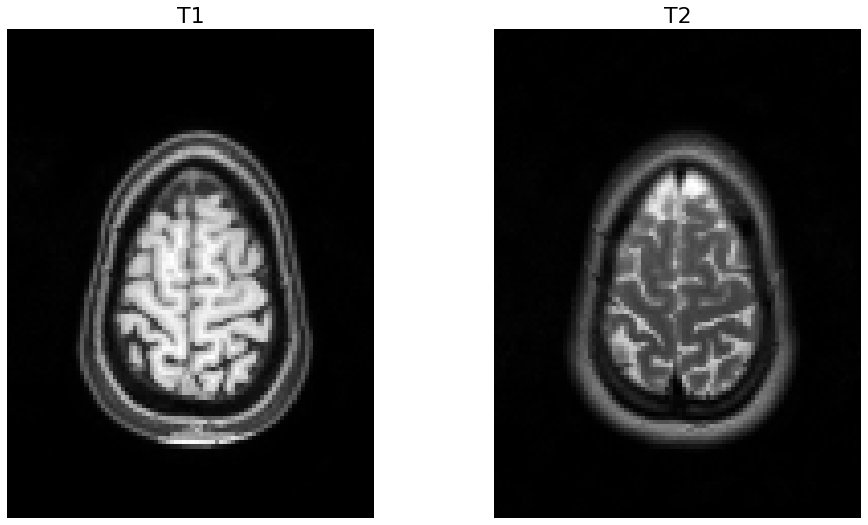

In [34]:
t1_ex, t2_ex = nib.load(t1_fns_sorted[0]).get_data(), nib.load(t2_fns_sorted[0]).get_data()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.imshow(t1_ex[:,100,:], cmap='gray'); ax1.set_title('T1',fontsize=22); ax1.axis('off'); 
ax2.imshow(t2_ex[:,100,:], cmap='gray'); ax2.set_title('T2',fontsize=22); ax2.axis('off'); 